# Modelling using value of R0

##### Modelling with R0 as target variable. R0 represents the average number of people infected by one infectious individual. 

## Import libraries

In [2814]:
import pandas as pd, numpy as np, time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV

# Librerías para plots
from sklearn import tree
#import graphviz
from scipy.stats import norm
from scipy.stats import t
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

## Read file and prepare data 

In [2815]:
#df = pd.read_csv('/Users/lucas_botella/Downloads/df_covid_processed.csv')
#df = pd.read_csv('/Users/lucas_botella/Downloads/cluster_covid_data.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/raw_deaths_covid_data.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/cluster_per_deaths_for_model.csv')
df=pd.read_csv('/Users/lucas_botella/Downloads/raw_deaths_covid_data.csv')

del df['Unnamed: 0']
del df['Excess mortality P-scores, all ages Prev 18 days']
del df['Excess mortality P-scores, all ages']

#del df['number_of_arrivals']
#del df['doctors_per_1000']
#del df['nurses_per_1000']
#del df['beds_per_1000']
#del df['urban_population']
#del df['life_expectancy']
#del df['%youth_unemployment_total']

accumulated=[]
country='AUS'
cumsum=0
for index, row in df.iterrows():
    country_last=row['Code']
    
    if(country!=country_last):
        
        cumsum=0
        country=row['Code']
        
    else:
        
        if(row['deaths_prev_18']  > 0):
            cumsum=cumsum+row['deaths_prev_18'] 
    
    accumulated.append(cumsum)

df['accumulated']=accumulated
df['accumulated']=df['accumulated']/df['average_deaths_2015_2019_all_ages']
df=df[[c for c in df if c not in ['deaths']] 
       + ['deaths']]

df['deaths_prev_18']=df['deaths_prev_18']+df['average_deaths_2015_2019_all_ages']
df['deaths']=df['deaths']+df['average_deaths_2015_2019_all_ages']
df['R0']=df['deaths']/df['deaths_prev_18']

del df['deaths']
del df['average_deaths_2015_2019_all_ages']
del df['month']

df

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,contact_tracing,testing_policy,...,nurses_per_1000,beds_per_1000,number_of_arrivals,urban_population,total_vaccinations_per_100,%youth_unemployment_total,life_expectancy,deaths_prev_18,accumulated,R0
0,AUS,2020-03-09,0.84,1.51,-1.05,6.24,-1.57,9.37,2.00,1.00,...,11.92,3.84,8263000.00,85.90,nan,11.84,82.75,3319.45,0.06,0.99
1,AUS,2020-03-16,0.98,2.06,-1.20,8.94,-0.10,11.00,2.00,1.00,...,11.92,3.84,8263000.00,85.90,nan,11.84,82.75,3267.87,0.11,1.00
2,AUS,2020-03-23,1.29,7.04,-0.82,8.06,-0.82,10.18,2.00,1.00,...,11.92,3.84,8263000.00,85.90,nan,11.84,82.75,3280.06,0.16,1.00
3,AUS,2020-03-30,-0.12,10.12,0.10,2.06,-1.76,5.98,2.00,1.00,...,11.92,3.84,8263000.00,85.90,nan,11.84,82.75,3272.25,0.20,1.02
4,AUS,2020-04-06,-4.49,23.73,2.45,-11.00,-12.08,5.08,2.00,1.00,...,11.92,3.84,8263000.00,85.90,nan,11.84,82.75,2683.24,0.29,1.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,USA,2021-01-18,-25.22,-9.78,14.10,-41.08,-15.59,-44.10,1.00,3.00,...,11.89,2.87,75608000.00,82.06,nan,8.30,78.54,104743.95,8.28,0.97
2078,USA,2021-01-25,-23.65,-10.57,12.59,-40.00,-20.24,-34.12,1.00,3.00,...,11.89,2.87,75608000.00,82.06,nan,8.30,78.54,107476.33,8.73,0.93
2079,USA,2021-02-01,-24.39,-11.84,10.90,-39.94,-22.00,-27.75,1.00,3.00,...,11.89,2.87,75608000.00,82.06,0.31,8.30,78.54,79100.94,11.57,0.95
2080,USA,2021-02-08,-25.04,-13.69,10.82,-40.82,-17.67,-29.86,1.00,3.00,...,11.89,2.87,75608000.00,82.06,0.91,8.30,78.54,77463.86,11.91,0.93


In [2816]:
df.columns

Index(['Code', 'Date', 'retail_and_recreation', 'grocery_and_pharmacy',
       'residential', 'transit_stations', 'parks', 'workplaces',
       'contact_tracing', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'debt_relief', 'income_support', 'Holiday', 'temp', 'prcp',
       'doctors_per_1000', 'nurses_per_1000', 'beds_per_1000',
       'number_of_arrivals', 'urban_population', 'total_vaccinations_per_100',
       '%youth_unemployment_total', 'life_expectancy', 'deaths_prev_18',
       'accumulated', 'R0'],
      dtype='object')

In [2813]:
#df=df[df['Code']!='ECU']

#### Feature Engineering

In [2817]:
df['nurses_per_1000']=df.apply(lambda x: x['nurses_per_1000'] if x['deaths_prev_18'] <= 0 else 
         x['nurses_per_1000'] - (x['nurses_per_1000']*x['deaths_prev_18']), axis=1)
df['doctors_per_1000']=df.apply(lambda x: x['doctors_per_1000'] if x['deaths_prev_18'] <= 0 else 
         x['doctors_per_1000'] - (x['doctors_per_1000']*x['deaths_prev_18']), axis=1)
df['beds_per_1000']=df.apply(lambda x: x['beds_per_1000'] if x['deaths_prev_18'] <= 0 else 
         x['beds_per_1000'] - (x['beds_per_1000']*x['deaths_prev_18']), axis=1)
df

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,contact_tracing,testing_policy,...,nurses_per_1000,beds_per_1000,number_of_arrivals,urban_population,total_vaccinations_per_100,%youth_unemployment_total,life_expectancy,deaths_prev_18,accumulated,R0
0,AUS,2020-03-09,0.84,1.51,-1.05,6.24,-1.57,9.37,2.00,1.00,...,-39555.95,-12742.86,8263000.00,85.90,nan,11.84,82.75,3319.45,0.06,0.99
1,AUS,2020-03-16,0.98,2.06,-1.20,8.94,-0.10,11.00,2.00,1.00,...,-38941.08,-12544.78,8263000.00,85.90,nan,11.84,82.75,3267.87,0.11,1.00
2,AUS,2020-03-23,1.29,7.04,-0.82,8.06,-0.82,10.18,2.00,1.00,...,-39086.41,-12591.60,8263000.00,85.90,nan,11.84,82.75,3280.06,0.16,1.00
3,AUS,2020-03-30,-0.12,10.12,0.10,2.06,-1.76,5.98,2.00,1.00,...,-38993.25,-12561.58,8263000.00,85.90,nan,11.84,82.75,3272.25,0.20,1.02
4,AUS,2020-04-06,-4.49,23.73,2.45,-11.00,-12.08,5.08,2.00,1.00,...,-31972.32,-10299.81,8263000.00,85.90,nan,11.84,82.75,2683.24,0.29,1.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,USA,2021-01-18,-25.22,-9.78,14.10,-41.08,-15.59,-44.10,1.00,3.00,...,-1245393.63,-300612.25,75608000.00,82.06,nan,8.30,78.54,104743.95,8.28,0.97
2078,USA,2021-01-25,-23.65,-10.57,12.59,-40.00,-20.24,-34.12,1.00,3.00,...,-1277881.70,-308454.20,75608000.00,82.06,nan,8.30,78.54,107476.33,8.73,0.93
2079,USA,2021-02-01,-24.39,-11.84,10.90,-39.94,-22.00,-27.75,1.00,3.00,...,-940498.35,-227016.84,75608000.00,82.06,0.31,8.30,78.54,79100.94,11.57,0.95
2080,USA,2021-02-08,-25.04,-13.69,10.82,-40.82,-17.67,-29.86,1.00,3.00,...,-921033.35,-222318.39,75608000.00,82.06,0.91,8.30,78.54,77463.86,11.91,0.93


In [2818]:
df.sort_values('R0')

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,contact_tracing,testing_policy,...,nurses_per_1000,beds_per_1000,number_of_arrivals,urban_population,total_vaccinations_per_100,%youth_unemployment_total,life_expectancy,deaths_prev_18,accumulated,R0
1329,LUX,2020-09-07,-25.29,-17.63,8.73,-22.20,118.98,-42.11,2.00,3.00,...,nan,-424.63,1054000.00,90.73,nan,16.82,82.30,100.68,3.16,0.59
587,ECU,2020-05-04,-81.67,-66.02,35.92,-80.22,-76.82,-76.94,1.00,2.00,...,nan,-9756.47,1418000.00,63.67,nan,8.71,76.80,7020.05,11.41,0.61
642,ESP,2020-05-04,-90.65,-56.31,30.08,-84.22,-81.27,-71.18,1.00,1.00,...,-117820.30,-59612.65,75315000.00,80.08,nan,32.61,83.43,20072.60,4.52,0.63
588,ECU,2020-05-11,-79.20,-64.20,34.24,-78.80,-74.55,-73.45,1.00,2.00,...,nan,-7520.78,1418000.00,63.67,nan,8.71,76.80,5411.63,13.67,0.63
130,BEL,2020-09-07,-13.41,-9.78,7.84,-31.69,89.51,-32.39,2.00,2.00,...,nan,-16282.24,7481000.00,97.96,nan,14.25,81.60,2918.96,6.13,0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,ESP,2020-04-13,-88.35,-52.37,28.02,-82.20,-80.63,-65.73,1.00,1.00,...,-71584.99,-36219.32,75315000.00,80.08,nan,32.61,83.43,12196.06,1.03,1.66
109,BEL,2020-04-13,-76.06,-27.55,24.59,-67.61,-22.61,-59.43,1.00,1.00,...,nan,-12820.92,7481000.00,97.96,nan,14.25,81.60,2298.66,0.11,1.72
638,ESP,2020-04-06,-69.80,-25.35,19.39,-61.57,-57.76,-45.29,1.00,1.00,...,-51167.53,-25888.85,75315000.00,80.08,nan,32.61,83.43,8717.79,0.49,2.15
583,ECU,2020-04-06,-42.84,-18.29,17.69,-40.20,-40.61,-39.86,0.86,1.14,...,nan,-1987.70,1418000.00,63.67,nan,8.71,76.80,1431.00,3.89,2.63


Text(0.5, 1.0, 'R0')

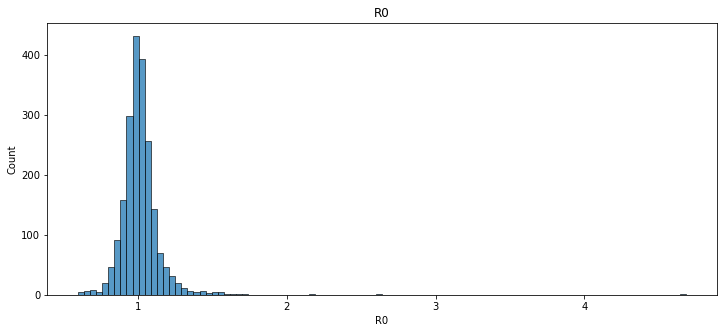

In [2819]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='R0', data=df, kde=False, bins=100, ax=axes);
axes.set_title('R0')

In [2820]:
df['R0'].describe()

count   2082.00
mean       1.01
std        0.15
min        0.59
25%        0.95
50%        1.00
75%        1.06
max        4.69
Name: R0, dtype: float64

In [2821]:
#df['total_vaccinations_per_100']=df['total_vaccinations_per_100'].apply(lambda x : x if x > 0 else 0)

In [2822]:
#df=df.fillna(df.median())

In [2823]:
X=df[df.columns[2:-1]]
y=df['R0']

## Apply model and view results 

pip install xgboost

In [2824]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor

## XGBoost Regressor 

### GridSearchCV 

In [2825]:
import warnings
warnings.filterwarnings('ignore')

In [3087]:
# A parameter grid for XGBoost
params = {'max_depth': [10, 12, 15]}

# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1) 

grid = GridSearchCV(xgb, params, verbose=1)

In [3088]:
import datetime
date1=pd.Timestamp(2020, 1, 1)
date2=pd.Timestamp(2020, 5, 1)

X_1=df[(pd.to_datetime(df['Date']) <= date1) | (pd.to_datetime(df['Date']) >= date2)]
X_2=df[(pd.to_datetime(df['Date']) > date1) & (pd.to_datetime(df['Date']) < date2)]
X_train=X_1[X_1.columns[2:-1]]
X_test=X_2[X_2.columns[2:-1]]
y_train=X_1['R0']
y_test=X_2['R0']

In [3092]:
import datetime
date1=pd.Timestamp(2020, 12, 1)

X_1=df[(pd.to_datetime(df['Date']) <= date1)]
X_2=df[(pd.to_datetime(df['Date']) > date1)]
X_train=X_1[X_1.columns[2:-1]]
X_test=X_2[X_2.columns[2:-1]]
y_train=X_1['R0']
y_test=X_2['R0']

In [3090]:
X_2

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,contact_tracing,testing_policy,...,nurses_per_1000,beds_per_1000,number_of_arrivals,urban_population,total_vaccinations_per_100,%youth_unemployment_total,life_expectancy,deaths_prev_18,accumulated,R0
39,AUS,2020-12-07,-10.20,2.65,4.71,-36.67,-10.90,-9.84,2.00,2.00,...,-31394.86,-10113.78,8263000.00,85.90,nan,11.84,82.75,2634.80,0.98,0.96
40,AUS,2020-12-14,-9.71,2.24,4.84,-36.41,-13.14,-9.86,2.00,2.00,...,-30049.67,-9680.43,8263000.00,85.90,nan,11.84,82.75,2521.95,0.98,1.04
41,AUS,2020-12-21,-6.37,3.92,3.65,-33.88,-14.04,-8.08,2.00,2.00,...,-30085.62,-9692.01,8263000.00,85.90,nan,11.84,82.75,2524.96,0.99,1.03
42,AUS,2020-12-28,-4.55,5.00,3.43,-32.27,-13.16,-8.02,2.00,2.00,...,-31215.10,-10055.87,8263000.00,85.90,nan,11.84,82.75,2619.72,1.03,1.00
43,AUS,2021-01-04,-2.59,6.35,3.65,-32.02,-16.02,-9.33,2.00,2.00,...,-37901.27,-12209.80,8263000.00,85.90,nan,11.84,82.75,3180.64,0.87,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,USA,2021-01-18,-25.22,-9.78,14.10,-41.08,-15.59,-44.10,1.00,3.00,...,-1245393.63,-300612.25,75608000.00,82.06,nan,8.30,78.54,104743.95,8.28,0.97
2078,USA,2021-01-25,-23.65,-10.57,12.59,-40.00,-20.24,-34.12,1.00,3.00,...,-1277881.70,-308454.20,75608000.00,82.06,nan,8.30,78.54,107476.33,8.73,0.93
2079,USA,2021-02-01,-24.39,-11.84,10.90,-39.94,-22.00,-27.75,1.00,3.00,...,-940498.35,-227016.84,75608000.00,82.06,0.31,8.30,78.54,79100.94,11.57,0.95
2080,USA,2021-02-08,-25.04,-13.69,10.82,-40.82,-17.67,-29.86,1.00,3.00,...,-921033.35,-222318.39,75608000.00,82.06,0.91,8.30,78.54,77463.86,11.91,0.93


In [3113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [3114]:
%%time
grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   10.6s finished


CPU times: user 11.7 s, sys: 35.2 ms, total: 11.8 s
Wall time: 11.8 s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None, nthread=-1,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=

In [3115]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

## Model evaluation metrics

### Test Set

In [3116]:
y_pred=grid.best_estimator_.predict(X_test)

In [3117]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.08702098257020525
mse score is 0.03583944596273635
rmse score is 0.18931308978181186
r2 score is -0.9459960606012521
mape score is 8.233264672074684


## Train Set

In [3118]:
y_pred_train=grid.best_estimator_.predict(X_train)

In [3119]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.0006305576078389287
mse score is 7.981446220414732e-07
rmse score is 0.0008933894011244331
r2 score is 0.9999641013902126
mape score is 0.06252935867515823


In [3120]:
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
df_eval

,Actual,Predicted,Difference
388,0.94,1.01,0.07
2059,0.95,0.97,0.02
1701,1.02,1.05,0.03
1342,1.23,1.09,0.15
1323,1.06,1.07,0.01
...,...,...,...
61,0.99,0.98,0.01
1374,1.06,0.96,0.11
1862,0.96,1.07,0.11
276,1.00,0.97,0.03


Text(0.5, 1.0, 'R0_Predicted')

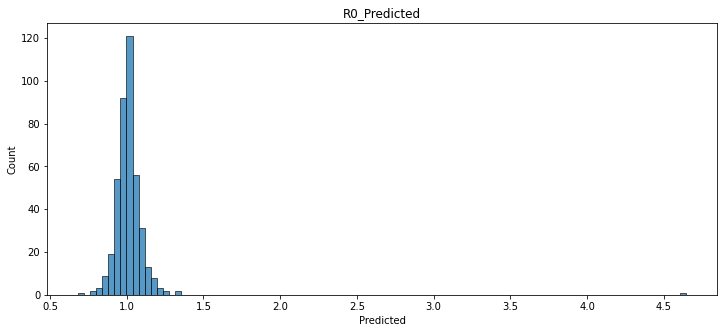

In [3121]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Predicted', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Predicted')

Text(0.5, 1.0, 'R0_Actual')

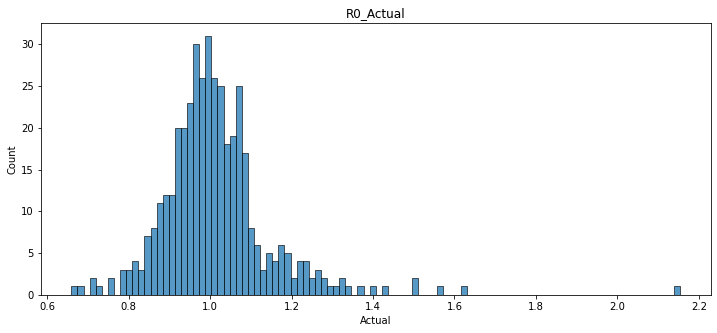

In [3122]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Actual', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Actual')

## Model evaluation plots

### Difference Histogram 

Text(0.5, 1.0, 'Difference Histogram')

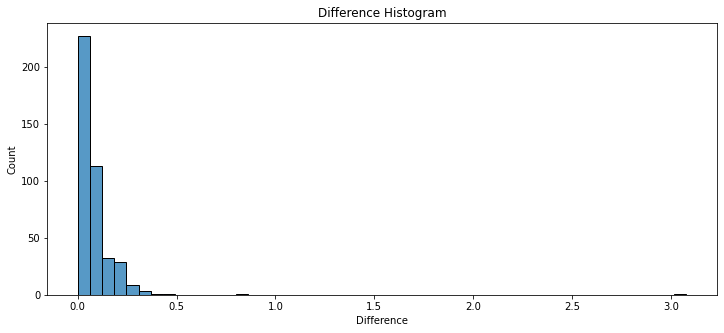

In [3123]:
# plot difference hist
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Difference', data=df_eval, kde=False, bins=50, ax=axes);
axes.set_title('Difference Histogram')

### Actual vs Predicted

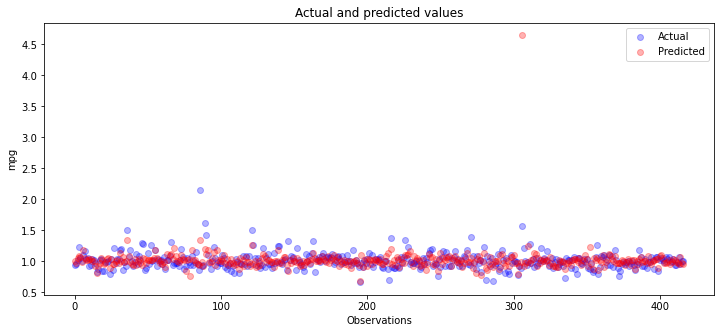

In [3124]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(12,5))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

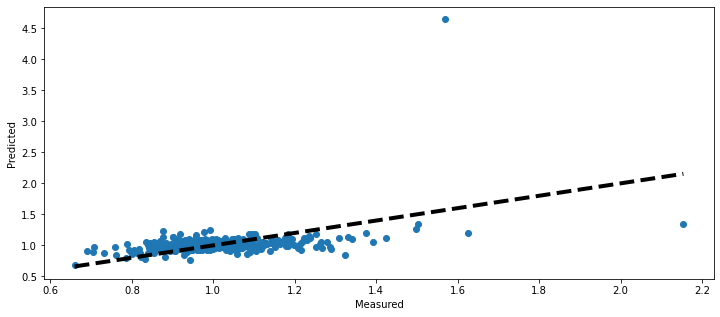

In [3125]:
fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

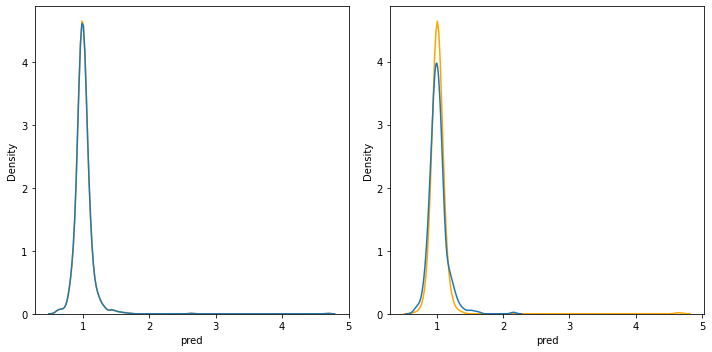

In [3126]:
import seaborn as sns
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_pred_train

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1], color='orange')
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [3127]:
res_df_train

,pred,test,dif,dif_abs,dif%
1299,0.86,0.86,0.00,0.00,0.06
702,1.15,1.15,-0.00,0.00,-0.03
553,0.96,0.96,0.00,0.00,0.07
520,1.01,1.01,-0.00,0.00,-0.09
1108,1.01,1.01,-0.00,0.00,-0.02
...,...,...,...,...,...
1593,0.96,0.96,0.00,0.00,0.04
1147,1.03,1.03,-0.00,0.00,-0.08
1766,1.00,1.00,-0.00,0.00,-0.03
1122,1.11,1.11,-0.00,0.00,-0.12


In [3128]:
mae_test = np.round(res_df_test['dif_abs'].mean(),2)
gae_test = np.round(res_df_test['dif_abs'].sum(),2)
error_test_rate_abs = np.round(100*gae_test/res_df_test['test'].sum(),2)
error_test = np.round(res_df_test['dif'].sum(),2)
error_test_rate = np.round(100*error_test/res_df_test['test'].sum(),2)
print('El error absoluto medio es: ', mae_test)
print('El error global es: ', error_test)
print('La tasa de error global es: %',error_test_rate)

El error absoluto medio es:  0.09
El error global es:  1.81
La tasa de error global es: % 0.43


In [3129]:
res_df_test.sort_values('dif%')

,pred,test,dif,dif_abs,dif%
638,1.34,2.15,-0.82,0.82,-37.91
1473,0.85,1.32,-0.47,0.47,-35.66
1478,0.95,1.29,-0.34,0.34,-26.50
633,1.20,1.63,-0.43,0.43,-26.45
1351,0.92,1.22,-0.30,0.30,-24.42
...,...,...,...,...,...
450,1.02,0.79,0.23,0.23,29.56
1456,0.91,0.69,0.22,0.22,32.02
1504,0.97,0.71,0.26,0.26,36.81
948,1.23,0.88,0.35,0.35,40.05


In [3130]:
res_df_test[(res_df_test['test']>1.1) & (res_df_test['pred']<1)]

,pred,test,dif,dif_abs,dif%
1658,0.96,1.21,-0.24,0.24,-20.08
882,0.99,1.18,-0.19,0.19,-16.43
410,0.95,1.12,-0.17,0.17,-15.15
1478,0.95,1.29,-0.34,0.34,-26.50
1910,0.97,1.15,-0.18,0.18,-15.52
1877,0.96,1.27,-0.31,0.31,-24.17
1327,0.90,1.14,-0.24,0.24,-20.76
327,0.97,1.25,-0.29,0.29,-22.92
1473,0.85,1.32,-0.47,0.47,-35.66
656,1.00,1.12,-0.12,0.12,-11.11


In [3131]:
np.abs(res_df_test['dif_abs']).mean()/res_df_test['test'].sum()

0.00020613349352271542

In [3132]:
np.abs(res_df_test['dif%']).mean()

8.233069544364508

In [3133]:
#MAPE value
np.abs(res_df_test['dif%']).describe()

count   417.00
mean      8.23
std      11.73
min       0.01
25%       2.62
50%       5.45
75%      10.17
max     196.33
Name: dif%, dtype: float64

In [3015]:
np.abs(res_df_test['test']).describe()

count   363.00
mean      0.96
std       0.11
min       0.67
25%       0.90
50%       0.96
75%       1.03
max       1.43
Name: test, dtype: float64

In [3016]:
np.abs(res_df_test['pred']).describe()

count   363.00
mean      1.00
std       0.12
min       0.76
25%       0.93
50%       0.99
75%       1.05
max       1.55
Name: pred, dtype: float64

## Feature importance 

In [3008]:
import xgboost
from xgboost import plot_importance
from xgboost import plot_tree

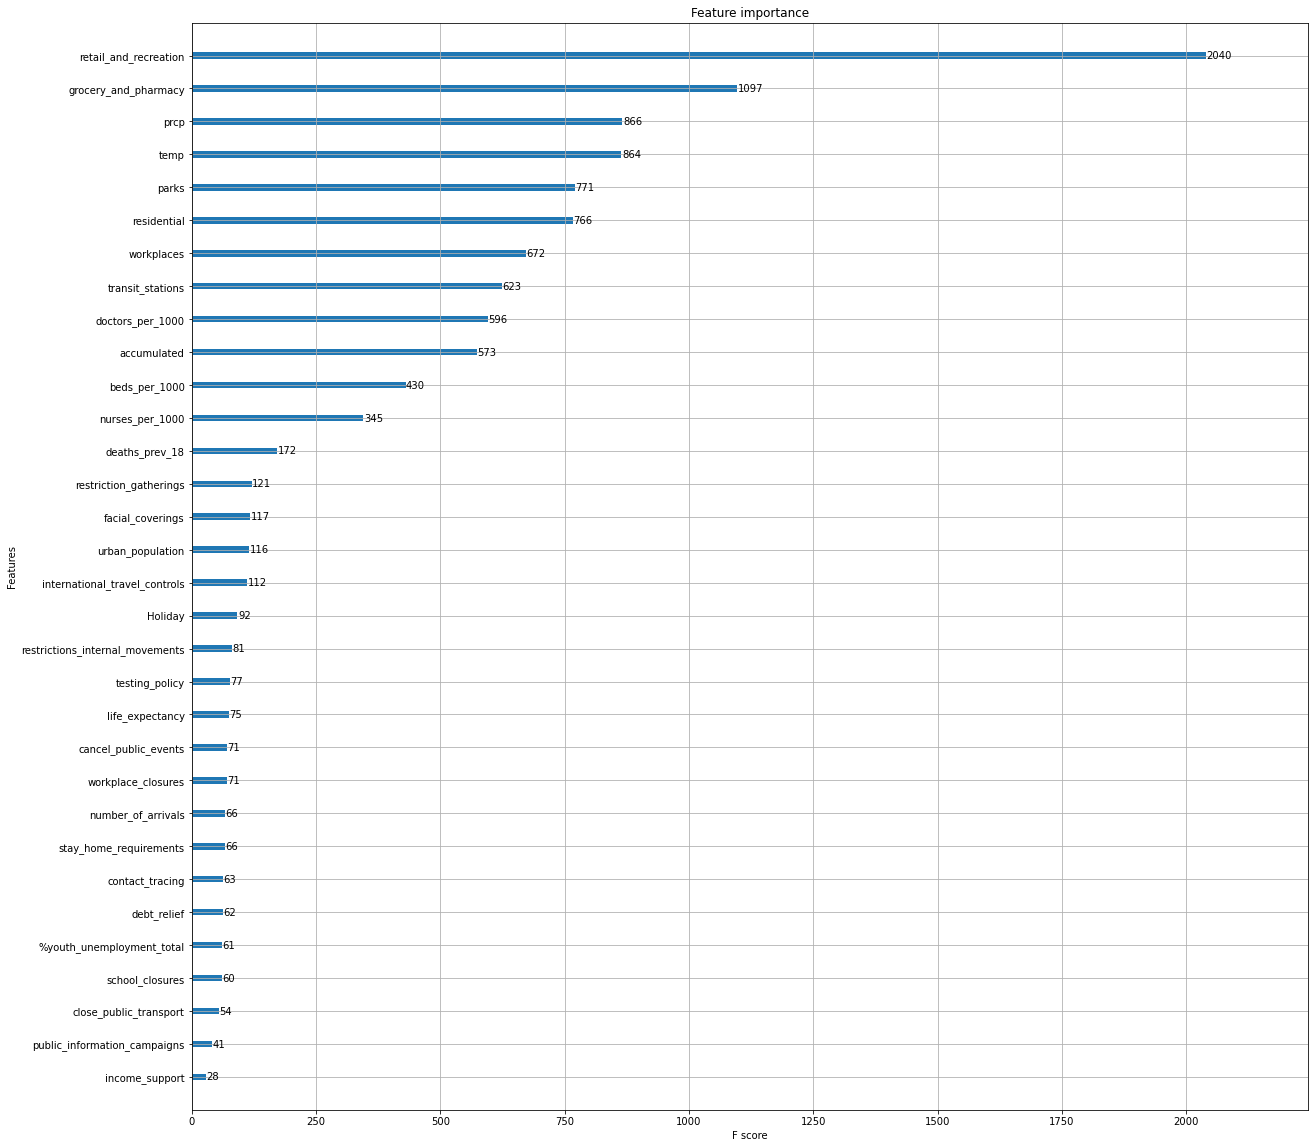

In [3009]:
xgboost.plot_importance(grid.best_estimator_)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

In [2191]:
import lightgbm as lgb

In [2321]:
hyper_params = {
    'metric': ['mape'],
    "max_depth": 15,
    "num_leaves": 256,  
    "max_bin": 512,
    "num_iterations": 10000,
    "n_estimators": 20
}

In [2322]:
gbm = lgb.LGBMRegressor(**hyper_params)

In [2323]:
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='mape',
        early_stopping_rounds=1000)

[1]	valid_0's mape: 0.0799763
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's mape: 0.0790139
[3]	valid_0's mape: 0.0782141
[4]	valid_0's mape: 0.0778104
[5]	valid_0's mape: 0.0773493
[6]	valid_0's mape: 0.0771382
[7]	valid_0's mape: 0.0766633
[8]	valid_0's mape: 0.0758749
[9]	valid_0's mape: 0.0756547
[10]	valid_0's mape: 0.0753819
[11]	valid_0's mape: 0.0754647
[12]	valid_0's mape: 0.0754724
[13]	valid_0's mape: 0.0751508
[14]	valid_0's mape: 0.0750756
[15]	valid_0's mape: 0.0750733
[16]	valid_0's mape: 0.0751835
[17]	valid_0's mape: 0.075169
[18]	valid_0's mape: 0.0752366
[19]	valid_0's mape: 0.0752853
[20]	valid_0's mape: 0.0751623
[21]	valid_0's mape: 0.0750325
[22]	valid_0's mape: 0.0751938
[23]	valid_0's mape: 0.0750817
[24]	valid_0's mape: 0.0751823
[25]	valid_0's mape: 0.075222
[26]	valid_0's mape: 0.075501
[27]	valid_0's mape: 0.0754631
[28]	valid_0's mape: 0.075271
[29]	valid_0's mape: 0.0753789
[30]	valid_0's mape: 0.0754336
[31]	valid_0's mape:

[292]	valid_0's mape: 0.0747329
[293]	valid_0's mape: 0.0747692
[294]	valid_0's mape: 0.074779
[295]	valid_0's mape: 0.0748063
[296]	valid_0's mape: 0.0748192
[297]	valid_0's mape: 0.0748297
[298]	valid_0's mape: 0.0748301
[299]	valid_0's mape: 0.0747828
[300]	valid_0's mape: 0.0748024
[301]	valid_0's mape: 0.0748102
[302]	valid_0's mape: 0.0748158
[303]	valid_0's mape: 0.0748341
[304]	valid_0's mape: 0.0748402
[305]	valid_0's mape: 0.0748649
[306]	valid_0's mape: 0.0748636
[307]	valid_0's mape: 0.0748976
[308]	valid_0's mape: 0.0748977
[309]	valid_0's mape: 0.07491
[310]	valid_0's mape: 0.0748191
[311]	valid_0's mape: 0.0748607
[312]	valid_0's mape: 0.0748619
[313]	valid_0's mape: 0.0748724
[314]	valid_0's mape: 0.0748864
[315]	valid_0's mape: 0.0748897
[316]	valid_0's mape: 0.0749398
[317]	valid_0's mape: 0.0749231
[318]	valid_0's mape: 0.074814
[319]	valid_0's mape: 0.0748397
[320]	valid_0's mape: 0.0748086
[321]	valid_0's mape: 0.0748348
[322]	valid_0's mape: 0.0748336
[323]	valid_

[565]	valid_0's mape: 0.0748033
[566]	valid_0's mape: 0.0748088
[567]	valid_0's mape: 0.0748029
[568]	valid_0's mape: 0.0748216
[569]	valid_0's mape: 0.0748256
[570]	valid_0's mape: 0.0748099
[571]	valid_0's mape: 0.0748146
[572]	valid_0's mape: 0.0747625
[573]	valid_0's mape: 0.0747827
[574]	valid_0's mape: 0.0747936
[575]	valid_0's mape: 0.0748273
[576]	valid_0's mape: 0.07483
[577]	valid_0's mape: 0.0748361
[578]	valid_0's mape: 0.0747921
[579]	valid_0's mape: 0.0747936
[580]	valid_0's mape: 0.0748021
[581]	valid_0's mape: 0.0748293
[582]	valid_0's mape: 0.0748315
[583]	valid_0's mape: 0.0748227
[584]	valid_0's mape: 0.0747849
[585]	valid_0's mape: 0.0747834
[586]	valid_0's mape: 0.074789
[587]	valid_0's mape: 0.0747682
[588]	valid_0's mape: 0.0747853
[589]	valid_0's mape: 0.0747914
[590]	valid_0's mape: 0.0748057
[591]	valid_0's mape: 0.0748096
[592]	valid_0's mape: 0.0748004
[593]	valid_0's mape: 0.0748163
[594]	valid_0's mape: 0.0747733
[595]	valid_0's mape: 0.0747859
[596]	valid

[850]	valid_0's mape: 0.0748952
[851]	valid_0's mape: 0.0748983
[852]	valid_0's mape: 0.0748916
[853]	valid_0's mape: 0.0748981
[854]	valid_0's mape: 0.0749018
[855]	valid_0's mape: 0.0749004
[856]	valid_0's mape: 0.074888
[857]	valid_0's mape: 0.0748887
[858]	valid_0's mape: 0.0748857
[859]	valid_0's mape: 0.0748994
[860]	valid_0's mape: 0.0748659
[861]	valid_0's mape: 0.0748579
[862]	valid_0's mape: 0.0748638
[863]	valid_0's mape: 0.0748298
[864]	valid_0's mape: 0.0748337
[865]	valid_0's mape: 0.0748382
[866]	valid_0's mape: 0.0748387
[867]	valid_0's mape: 0.0748718
[868]	valid_0's mape: 0.0748446
[869]	valid_0's mape: 0.0748429
[870]	valid_0's mape: 0.0748454
[871]	valid_0's mape: 0.0748452
[872]	valid_0's mape: 0.074841
[873]	valid_0's mape: 0.0748562
[874]	valid_0's mape: 0.0748565
[875]	valid_0's mape: 0.0748521
[876]	valid_0's mape: 0.0748637
[877]	valid_0's mape: 0.0748621
[878]	valid_0's mape: 0.0748672
[879]	valid_0's mape: 0.0748643
[880]	valid_0's mape: 0.0748636
[881]	vali

[1130]	valid_0's mape: 0.0748168
[1131]	valid_0's mape: 0.0748271
[1132]	valid_0's mape: 0.0748222
[1133]	valid_0's mape: 0.0748321
[1134]	valid_0's mape: 0.0748308
[1135]	valid_0's mape: 0.0748309
[1136]	valid_0's mape: 0.0748557
[1137]	valid_0's mape: 0.0748489
[1138]	valid_0's mape: 0.0748416
[1139]	valid_0's mape: 0.0748358
[1140]	valid_0's mape: 0.0748379
[1141]	valid_0's mape: 0.0748411
[1142]	valid_0's mape: 0.0748353
[1143]	valid_0's mape: 0.0748328
[1144]	valid_0's mape: 0.0748354
[1145]	valid_0's mape: 0.0748314
[1146]	valid_0's mape: 0.0748232
[1147]	valid_0's mape: 0.0748195
[1148]	valid_0's mape: 0.074806
[1149]	valid_0's mape: 0.0748053
[1150]	valid_0's mape: 0.0748092
[1151]	valid_0's mape: 0.0748349
[1152]	valid_0's mape: 0.0748303
[1153]	valid_0's mape: 0.074836
[1154]	valid_0's mape: 0.0748197
[1155]	valid_0's mape: 0.0748207
[1156]	valid_0's mape: 0.0748196
[1157]	valid_0's mape: 0.0748311
[1158]	valid_0's mape: 0.0748322
[1159]	valid_0's mape: 0.0748514
[1160]	valid

LGBMRegressor(max_bin=512, max_depth=15, metric=['mape'], n_estimators=20,
              num_iterations=10000, num_leaves=256)

In [2324]:
def mape(y, y_pred):
    return np.mean(np.abs((y - y_pred) / y)) * 100

In [2325]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

In [2326]:
mape(y_pred, y_test)

8.008887985443824

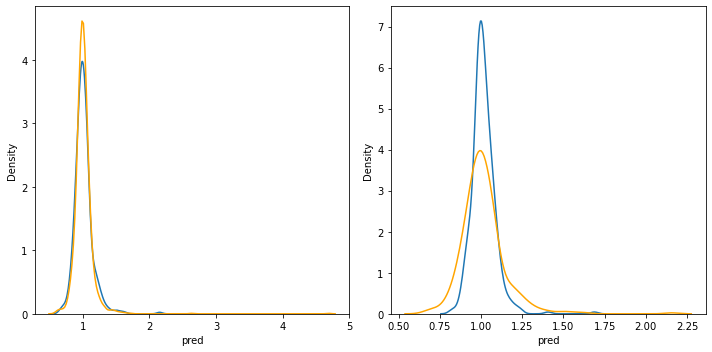

In [2327]:
import seaborn as sns
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_test

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0])
plot = sns.kdeplot(res_df_train['test'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1])
plot = sns.kdeplot(res_df_test['test'], ax=axes[1], color='orange')
fig.tight_layout()